In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import pdb
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import  qExpectedImprovement
from matplotlib.cm import ScalarMappable
from scipy.spatial import distance
import pdb
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition import PosteriorMean

NUM_GRID_PERDIM = 100
BATCH_SIZE = 8
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8
NUM_FILTERS = 5

TARGET = [1,0,0.5]
expt = {}
EXPT_ID = 0

INFO: Using numpy backend


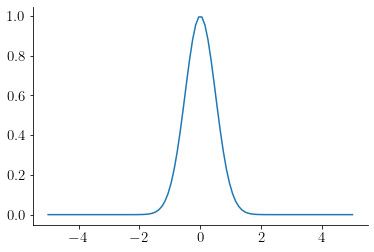

In [3]:
lambda_ = np.linspace(-5,5,num=100)
def gaussian(a, b,c):
    return a*np.exp(-np.power(lambda_ - b, 2.) / (2 * np.power(c, 2.)))

yt = gaussian(*TARGET)

fig, ax = plt.subplots()
ax.plot(lambda_, yt)
plt.show()

In [4]:
# define search space
A = [-5,5]
bounds = torch.tensor(A).reshape(2,1).to(**tkwargs)
test_x = torch.linspace(-5, 5, 51).to(**tkwargs)

In [5]:
metric = 'euclidean'
d = lambda yi,yt : -distance.euclidean(yi,yt)

In [6]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()
    yi = gaussian(TARGET[0],x_np,TARGET[2])
    dist = d(yi, yt)
        
    expt[EXPT_ID] = [lambda_, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [7]:
def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 1]) torch.Size([8, 1])
0	[2.54576445]	[-4.18573809]
1	[-3.45083222]	[-4.18893194]
2	[1.513381]	[-3.97126079]
3	[0.45167208]	[-1.79951262]
4	[-3.70705888]	[-4.18887472]
5	[-4.94805926]	[-3.7635088]
6	[4.1697675]	[-4.18243361]
7	[1.87592745]	[-4.12643147]


In [8]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [9]:
def selector(f, q = BATCH_SIZE):
    new_x, acq_values = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj, acq_values

In [10]:
def agent(model):
    with torch.no_grad():
        test_x = torch.linspace(-5, 5, 100).to(**tkwargs)
        posterior = model.posterior(test_x)
        out_test = posterior.mean
        return test_x[out_test.argmax()].cpu().numpy()

In [13]:
def plot_EI(f, new_x):
    fig, ax = plt.subplots()
    with torch.no_grad():
        ax.plot(test_x.numpy(), f(test_x.reshape(51,1,1)).numpy(), label='EI', color='tab:blue')
        ax.scatter(new_x.numpy(), f(new_x.reshape(BATCH_SIZE,1,1)).numpy(), label='Selected', color='tab:orange')
        ax.set_xlabel(r'$\mathcal{X}$')
        ax.set_ylabel('EI')
        ax.legend()
        plt.show()

Sampled ID 	 Locations 	 Objectives 	 EI
Iteration : 1/10


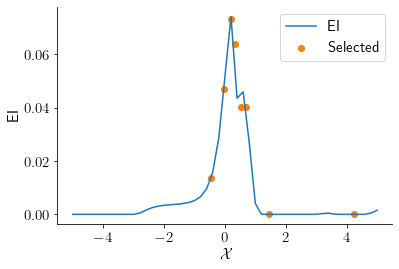

0	[0.33102713]	[-1.34952176]
1	[0.53816663]	[-2.10055852]
2	[1.43800644]	[-3.91514182]
3	[-0.03328265]	[-0.13938074]
4	[4.25311654]	[-4.17655611]
5	[0.18521442]	[-0.76924729]
6	[-0.45038981]	[-1.7949053]
7	[0.70559516]	[-2.62327456]
Optimal location from the surrogate : 0.4545
Iteration : 2/10


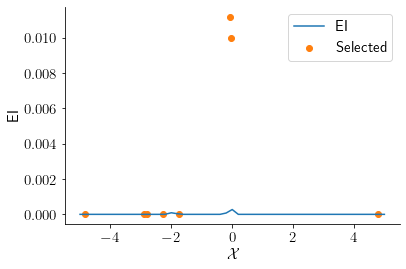

0	[-2.28874075]	[-4.17781448]
1	[-0.05198767]	[-0.21762665]
2	[4.78248166]	[-3.94804382]
3	[-2.81513103]	[-4.18819141]
4	[-0.08397028]	[-0.3511281]
5	[-1.73724498]	[-4.0852499]
6	[-2.8960291]	[-4.18847179]
7	[-4.84950466]	[-3.87994576]
Optimal location from the surrogate : -0.0505
Iteration : 3/10


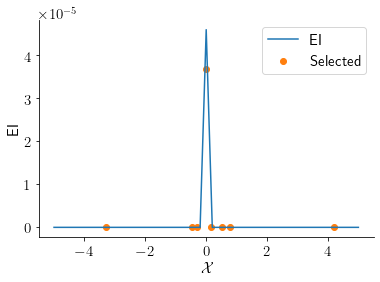

0	[-0.4641392]	[-1.84409606]
1	[0.79243774]	[-2.86053181]
2	[0.16339005]	[-0.67988992]
3	[4.19014144]	[-4.1812892]
4	[0.5242814]	[-2.05356741]
5	[-0.29226647]	[-1.19860411]
6	[-3.29988952]	[-4.18890953]
7	[0.00772234]	[-0.03234799]
Optimal location from the surrogate : -0.0505
Iteration : 4/10


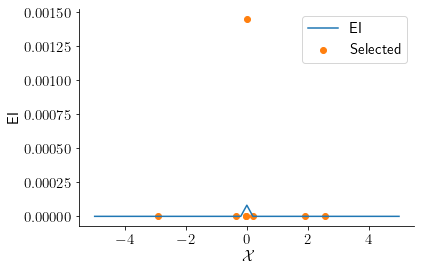

0	[-2.9234286]	[-4.18854189]
1	[-0.0145702]	[-0.06103059]
2	[1.90593179]	[-4.133183]
3	[-0.3617069]	[-1.46693826]
4	[0.21050516]	[-0.87211633]
5	[0.02051791]	[-0.08593945]
6	[-0.04083007]	[-0.17096381]
7	[2.55694021]	[-4.18591595]
Optimal location from the surrogate : 0.0505
Iteration : 5/10


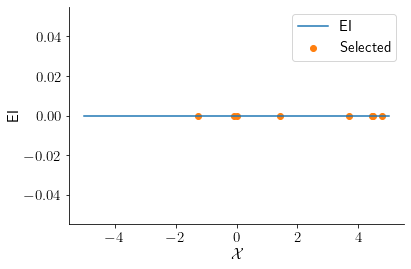

0	[1.44491231]	[-3.92072392]
1	[-0.07184959]	[-0.30058625]
2	[4.76930227]	[-3.9602623]
3	[-1.27512174]	[-3.75436497]
4	[0.01786814]	[-0.07484276]
5	[4.44091501]	[-4.14493418]
6	[3.70384157]	[-4.18887711]
7	[4.49898507]	[-4.12695456]
Optimal location from the surrogate : 0.0505
Iteration : 6/10


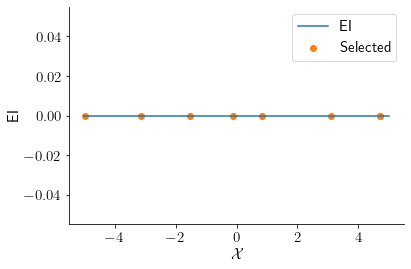

0	[-0.09977962]	[-0.41693357]
1	[0.84613841]	[-2.99523759]
2	[4.7299251]	[-3.99440718]
3	[-3.13594485]	[-4.18883657]
4	[-1.53479826]	[-3.9853704]
5	[3.11624384]	[-4.18882179]
6	[-4.97329681]	[-3.73113322]
7	[4.72611945]	[-3.99751878]
Optimal location from the surrogate : 0.0505
Iteration : 7/10


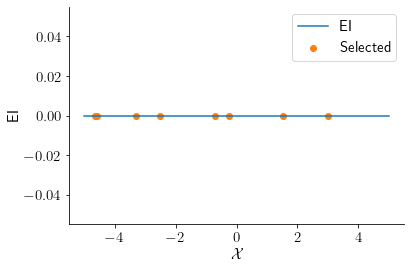

0	[-2.52701789]	[-4.18541765]
1	[-3.30571074]	[-4.18891096]
2	[-4.57496355]	[-4.09514856]
3	[1.52443784]	[-3.97864151]
4	[3.01500056]	[-4.1887126]
5	[-0.71250799]	[-2.6430316]
6	[-0.25475528]	[-1.05007398]
7	[-4.65013319]	[-4.05277729]
Optimal location from the surrogate : 0.0505
Iteration : 8/10


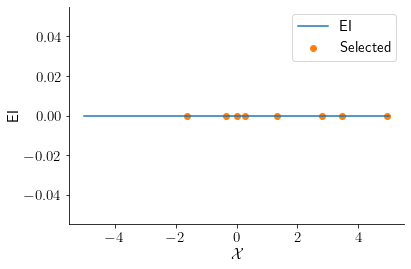

0	[1.32148369]	[-3.80615115]
1	[-0.35900765]	[-1.45668411]
2	[3.46620557]	[-4.18893242]
3	[0.02859797]	[-0.11977096]
4	[2.8227577]	[-4.18822336]
5	[-1.62614443]	[-4.03739119]
6	[0.271338]	[-1.1160177]
7	[4.95552438]	[-3.75402403]
Optimal location from the surrogate : 0.0505
Iteration : 9/10


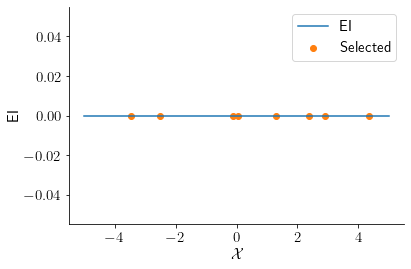

0	[4.35812315]	[-4.16299677]
1	[2.36904791]	[-4.18129206]
2	[1.29123684]	[-3.77294469]
3	[-2.50267659]	[-4.1849575]
4	[-3.47445412]	[-4.1889329]
5	[2.92093888]	[-4.18853617]
6	[-0.10641998]	[-0.44452867]
7	[0.04215502]	[-0.17650682]
Optimal location from the surrogate : 0.0505
Iteration : 10/10


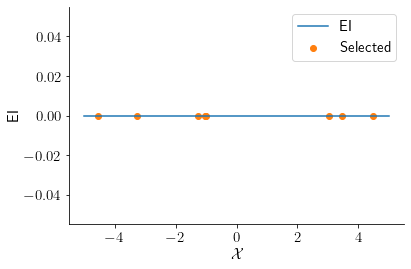

0	[3.03673443]	[-4.18874168]
1	[4.47102236]	[-4.13623095]
2	[-1.28149704]	[-3.76179028]
3	[3.47391624]	[-4.1889329]
4	[-3.28587229]	[-4.18890572]
5	[-4.56662443]	[-4.09915018]
6	[-0.99831046]	[-3.32718706]
7	[-1.0290271]	[-3.3854425]
Optimal location from the surrogate : 0.0505


In [14]:
# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives \t EI')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = best_f)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj, acq_values = selector(acquisition)
    plot_EI(acquisition, new_x)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    print('Optimal location from the surrogate : %2.4f'%float(agent(model)))
    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

In [ ]:
# Get into evaluation (predictive posterior) mode
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

model.eval()
mll.eval()
fig, ax = plt.subplots()
with torch.no_grad():
    posterior = model.posterior(test_x)
    lower, upper = posterior.mvn.confidence_region()
    ax.scatter(train_x.cpu().numpy(), train_obj.cpu().numpy(), s=10*batch_number,c='grey', 
               edgecolors=(0,0,0), label=r'$(x_{i}, y_{i})$')
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b', label=r'$\mu(x)$')
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), 
                    upper.cpu().numpy(), alpha=0.25, label='Confidence')

opt_x, opt_obj,_ = selector(PosteriorMean(model), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
ax.axvline(opt_x, color='tab:red', ls='--', label=r'$\hat{x_{t}}$')
ax.axvline(TARGET[1], color='tab:red', label=r'$x_{t}$')
fig.legend(ncol=2,loc='center', bbox_to_anchor=(0.6, 1.1))
plt.tight_layout()
ax.set_xlabel(r'$\mathcal{X}$')
ax.set_ylabel(r'$p(y|X,\mathcal{M})$')
plt.show()

In [ ]:
def plot_best_trace(ax, train_x, train_obj, target):
    train_x = train_x.cpu().numpy()
    proximities = np.abs(train_x-target[1])
    trace = np.asarray([min(proximities[batch_number<=b]) for b in np.unique(batch_number)])
    return ax.plot(np.arange(N_ITERATIONS+1),trace)

fig, ax = plt.subplots()
ax.axhline(0, label='Optimal', ls='--', lw='2.0', c='k')
plot_best_trace(ax, train_x, train_obj, TARGET)
ax.set_xlabel('Batch number')
ax.set_ylabel(r'$||x-x_{t}||_{2}$')
plt.show()